In [ ]:
#%cd C:\path\to\replication

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics as skl
import re
import os
import time
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import multiprocessing as mp
from functools import partial
from tqdm import tqdm
from scipy.sparse import csr_matrix

# Input file path
INPATH = r"data\full_table_v2.csv"
SAMPLE_SIZE = 1500

df = pd.read_csv(INPATH)
print(f"Read {len(df)} rows")

df = df[['master_id', 'year', 'style']]
df = df.drop_duplicates()
print(f"After filtering: {len(df)} rows")

Read 945761 rows
After filtering: 465458 rows


In [2]:
def similarity(row1, row2):
    """
    return the cosine pairwise similarity using the presence (not counts) of styles for the two rows.
    Order of styles doesn't matter in this implementation.
    """
    # Combine all styles to get the set of unique styles
    all_styles = set(row1['style']) | set(row2['style'])
    
    # Create binary vectors for each row (1 if style is present, 0 if absent)
    vec1 = np.array([1 if style in set(row1['style']) else 0 for style in all_styles])
    vec2 = np.array([1 if style in set(row2['style']) else 0 for style in all_styles])
    
    # Compute cosine similarity
    sim = cosine_similarity([vec1], [vec2])[0][0]
    return sim

# Kelly et al Implementation for Discogs Dataset

Kelly et al's algorithm (often described in my implementation as "taddy" after one of the other authors on that paper) is an algorithm to measure the "forward-lookingness" of a vectorized document.

This implementation:
1. Groups data by master_id and aggregates styles
2. Computes forward and backward similarity between masters
3. Calculates TADDY scores as the ratio of forward to backward similarity

In [3]:
# Group data by master_id and aggregate styles
def process_data(df):
    """
    Process dataframe to create a grouped version with all styles for each master_id
    """
    # Group by master_id and aggregate styles and years
    grouped = df.groupby('master_id').agg({
        'year': 'first',  # Assuming year is the same for all rows of a master_id
        'style': lambda x: list(x.dropna().unique())  # Collect all unique styles into a list
    }).reset_index()
    
    print(f"Processed {len(df)} rows into {len(grouped)} unique master_ids")
    return grouped

# Cohort class to store master_id data
class Cohort:
    """
    Stores key information for a master_id cohort
    """
    def __init__(self, row):
        self.master_id = row['master_id']
        self.year = row['year']
        self.styles = row['style']
    
    def get_year(self):
        return self.year
    
    def get_id(self):
        return self.master_id
    
    def get_styles(self):
        return self.styles

In [4]:
# TADDY algorithm components

def forward_similarity(cohort, all_cohorts, window=10, sample_size=100):
    """
    Calculate forward similarity - similarity to masters in the future
    
    Args:
        cohort: The cohort to calculate forward similarity for
        all_cohorts: List of all cohorts
        window: Year window to look forward
        sample_size: Number of future cohorts to sample for comparison
    
    Returns:
        Average similarity to cohorts in the forward window
    """
    year = cohort.get_year()
    # Get cohorts in the forward window
    future_cohorts = [c for c in all_cohorts if c.get_year() > year and c.get_year() <= year + window]
    
    if not future_cohorts:
        return 0.0
    
    # Sample from future cohorts if there are more than sample_size
    if len(future_cohorts) > sample_size:
        future_cohorts = np.random.choice(future_cohorts, size=sample_size, replace=False).tolist()
    
    # Calculate similarity to each future cohort
    similarities = []
    for future_cohort in future_cohorts:
        row1 = {'master_id': cohort.get_id(), 'style': cohort.get_styles()}
        row2 = {'master_id': future_cohort.get_id(), 'style': future_cohort.get_styles()}
        sim = similarity(row1, row2)
        similarities.append(sim)
    
    # Return average similarity
    return sum(similarities) / len(similarities)

def backward_similarity(cohort, all_cohorts, window=10, sample_size=100):
    """
    Calculate backward similarity - similarity to masters in the past
    
    Args:
        cohort: The cohort to calculate backward similarity for
        all_cohorts: List of all cohorts
        window: Year window to look backward
        sample_size: Number of past cohorts to sample for comparison
    
    Returns:
        Average similarity to cohorts in the backward window
    """
    year = cohort.get_year()
    # Get cohorts in the backward window
    past_cohorts = [c for c in all_cohorts if c.get_year() < year and c.get_year() >= year - window]
    
    if not past_cohorts:
        return 0.0
    
    # Sample from past cohorts if there are more than sample_size
    if len(past_cohorts) > sample_size:
        past_cohorts = np.random.choice(past_cohorts, size=sample_size, replace=False).tolist()
    
    # Calculate similarity to each past cohort
    similarities = []
    for past_cohort in past_cohorts:
        row1 = {'master_id': cohort.get_id(), 'style': cohort.get_styles()}
        row2 = {'master_id': past_cohort.get_id(), 'style': past_cohort.get_styles()}
        sim = similarity(row1, row2)
        similarities.append(sim)
    
    # Return average similarity
    return sum(similarities) / len(similarities)

def calculate_taddy(cohort, all_cohorts, window=10, sample_size=100):
    """
    Calculate TADDY score for a cohort
    
    Args:
        cohort: The cohort to calculate TADDY for
        all_cohorts: List of all cohorts
        window: Year window for forward/backward comparisons
        sample_size: Number of cohorts to sample for comparison
    
    Returns:
        TADDY score (forward similarity / backward similarity)
    """
    forward = forward_similarity(cohort, all_cohorts, window, sample_size)
    backward = backward_similarity(cohort, all_cohorts, window, sample_size)
    
    if backward == 0:
        return 99.0  # Handle division by zero
    if forward == 0:
        return 0.0   # Handle zero forward similarity
        
    return forward / backward

# Function to process a batch of cohorts in parallel
def process_cohort_batch(cohorts_batch, all_cohorts, window, year_range, sample_size):
    results = []
    for cohort in cohorts_batch:
        # Skip if outside year range
        if cohort.get_year() < year_range[0] or cohort.get_year() > year_range[1]:
            continue
            
        # Calculate scores
        forward = forward_similarity(cohort, all_cohorts, window, sample_size)
        backward = backward_similarity(cohort, all_cohorts, window, sample_size)
        taddy = calculate_taddy(cohort, all_cohorts, window, sample_size)
        
        # Store results
        results.append({
            'master_id': cohort.get_id(),
            'year': cohort.get_year(),
            'forward': forward,
            'backward': backward,
            'taddy': taddy
        })
    return results

In [5]:
# Run TADDY analysis on the dataset

# Process data
print("Processing data...")
grouped_df = process_data(df)

# Create cohorts
print("Creating cohorts...")
cohorts = [Cohort(row) for _, row in grouped_df.iterrows()]

# Define parameters
WINDOW = 10
YEAR_RANGE = (1950, 2015)  # Adjust as needed

# Step 1: Create a vocabulary of all unique styles
print("Creating style vocabulary...")
all_styles = set()
for cohort in cohorts:
    all_styles.update(cohort.get_styles())
style_to_idx = {style: i for i, style in enumerate(all_styles)}
num_styles = len(all_styles)
print(f"Found {num_styles} unique styles")

# Step 2: Vectorize cohorts' styles for faster similarity computation
print("Vectorizing style data...")
cohort_vectors = {}
for idx, cohort in enumerate(cohorts):
    # Create a binary vector for each cohort
    style_vec = np.zeros(num_styles, dtype=np.float32)
    for style in cohort.get_styles():
        style_vec[style_to_idx[style]] = 1.0
    
    # Normalize the vector for faster cosine similarity calculation
    norm = np.linalg.norm(style_vec)
    if norm > 0:
        style_vec = style_vec / norm
    
    cohort_vectors[cohort.get_id()] = style_vec

# Precompute year-based cohort groupings for faster window lookups
print("Organizing cohorts by year...")
year_to_cohorts = {}
cohort_years = np.array([c.get_year() for c in cohorts])
cohort_ids = np.array([c.get_id() for c in cohorts])
id_to_idx = {id: i for i, id in enumerate(cohort_ids)}

for year in range(min(cohort_years), max(cohort_years) + 1):
    year_to_cohorts[year] = np.where((cohort_years == year))[0]

# Function to get window indices efficiently
def get_window_cohorts(year, min_offset, max_offset):
    """Get cohorts within a time window relative to the given year"""
    indices = []
    for offset in range(min_offset, max_offset + 1):
        target_year = year + offset
        if target_year in year_to_cohorts:
            indices.extend(year_to_cohorts[target_year])
    return indices

# Efficient batch similarity calculation
def calculate_similarities(cohort_idx, comparison_indices, max_comparisons=SAMPLE_SIZE):
    """Calculate similarities between a cohort and a set of comparison cohorts"""
    # Sample if needed
    if len(comparison_indices) > max_comparisons:
        comparison_indices = np.random.choice(comparison_indices, max_comparisons, replace=False)
    
    if len(comparison_indices) == 0:
        return 0.0
        
    # Get the cohort vectors
    cohort_id = cohort_ids[cohort_idx]
    cohort_vec = cohort_vectors[cohort_id]
    
    # Calculate similarities in a vectorized way
    similarities = []
    for comp_idx in comparison_indices:
        comp_id = cohort_ids[comp_idx]
        comp_vec = cohort_vectors[comp_id]
        # Dot product of normalized vectors = cosine similarity
        sim = np.dot(cohort_vec, comp_vec)
        similarities.append(sim)
    
    return np.mean(similarities)

# Process cohorts in batches
print("Calculating TADDY scores...")
results = []
batch_size = 1000

for batch_start in tqdm(range(0, len(cohorts), batch_size), desc='Processing batches'):
    batch_end = min(batch_start + batch_size, len(cohorts))
    batch_indices = list(range(batch_start, batch_end))
    
    # Process only cohorts in the year range
    valid_indices = [i for i in batch_indices 
                    if YEAR_RANGE[0] <= cohorts[i].get_year() <= YEAR_RANGE[1]]
    
    batch_results = []
    for idx in tqdm(valid_indices, desc=f'Batch {batch_start//batch_size + 1}', leave=False):
        cohort = cohorts[idx]
        year = cohort.get_year()
        
        # Get forward and backward window cohorts
        forward_indices = get_window_cohorts(year, 1, WINDOW)
        backward_indices = get_window_cohorts(year, -WINDOW, -1)
        
        # Calculate similarities
        forward_sim = calculate_similarities(idx, forward_indices)
        backward_sim = calculate_similarities(idx, backward_indices)
        
        # Calculate TADDY score
        taddy_score = 99.0 if backward_sim == 0 else (0.0 if forward_sim == 0 else forward_sim / backward_sim)
        
        # Store results
        batch_results.append({
            'master_id': cohort.get_id(),
            'year': year,
            'forward': forward_sim,
            'backward': backward_sim,
            'taddy': taddy_score
        })
    
    results.extend(batch_results)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary
print(f"TADDY analysis complete for {len(results_df)} masters")
print("\nSummary statistics:")
print(results_df.describe())

# Show first few results
print("\nSample results:")
results_df.head()

Processing data...
Processed 465458 rows into 271445 unique master_ids
Creating cohorts...
Creating style vocabulary...
Found 632 unique styles
Vectorizing style data...
Organizing cohorts by year...
Calculating TADDY scores...


Processing batches:   0%|          | 0/272 [00:03<?, ?it/s]


KeyboardInterrupt: 

Results saved to: C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\taddy_results.csv


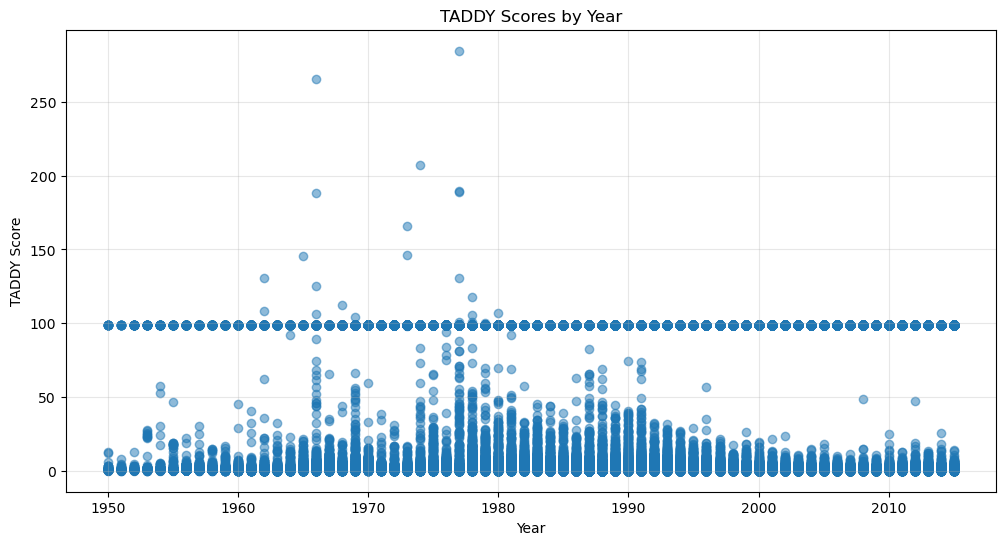

In [ ]:
# Save results to CSV
output_path = r"data\taddy_results.csv"
results_df.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

In [ ]:
# Filter out taddy values that are 0 or 99
filtered_taddy = results_df[(results_df['taddy'] != 0) & (results_df['taddy'] != 99)]['taddy']

# Calculate and print summary statistics
summary_stats = filtered_taddy.describe()
print("Summary statistics for TADDY (excluding 0 and 99):")
print(summary_stats)

Summary statistics for TADDY (excluding 0 and 99):
count    202173.000000
mean          1.388402
std           2.896994
min           0.012910
25%           0.664582
50%           0.979729
75%           1.405060
max         284.761261
Name: taddy, dtype: float64
